In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
import sys, os
import torch
import argparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import cv2
#import scipy.misc as m ## USE scipy (< v1.2.0) TO READ THE IMAGE TO PRODUCE THE RESULTS REPORTED IN THE PAPER
from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# from models import get_model
# from loaders import get_loader
# from utils import convert_state_dict

from collections import OrderedDict

In [4]:
def convert_state_dict(state_dict):
    """Converts a state dict saved from a dataParallel module to normal 
       module state_dict inplace
       :param state_dict is the loaded DataParallel model_state
    
    """
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    return new_state_dict

In [5]:
from models.Dewarp.densenet import dnetccnl
from models.Dewarp.unet_attention import UnetGenerator

In [6]:
def get_model(name, n_classes=1, filters=64,version=None,in_channels=3, is_batchnorm=True, norm='batch', model_path=None, use_sigmoid=True, layers=3):
    if name == 'dnetccnl':
        model = dnetccnl(img_size=128, in_channels=in_channels, out_channels=n_classes, filters=32)
    elif name == 'unetnc':
        model = UnetGenerator(input_nc=in_channels, output_nc=n_classes, num_downs=7)

    return model

In [ ]:


wc_model_path = "./weights/Dewarp/unetnc_doc3d.pkl"
bm_model_path = "./weights/Dewarp/dnetccnl_doc3d.pkl"


wc_n_classes = 3
bm_n_classes = 2

wc_img_size=(256,256)
bm_img_size=(128,128)





In [10]:
# Predict
htan = nn.Hardtanh(0,1.0)
wc_model = get_model('unetnc', wc_n_classes, in_channels=3)

wc_state = convert_state_dict(torch.load(wc_model_path)['model_state'])
wc_model.load_state_dict(wc_state)
wc_model.eval()

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

In [11]:
bm_model = get_model('dnetccnl', bm_n_classes, in_channels=3)
bm_state = convert_state_dict(torch.load(bm_model_path)['model_state'])
bm_model.load_state_dict(bm_state)
bm_model.eval()

dnetccnl(
  (encoder): waspDenseEncoder128(
    (main): Sequential(
      (0): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(5, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): DenseBlockEncoder(
        (layers): ModuleList(
          (0): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (1): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (2): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): C

In [13]:
wc_model.to(device)
bm_model.to(device)


dnetccnl(
  (encoder): waspDenseEncoder128(
    (main): Sequential(
      (0): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(5, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): DenseBlockEncoder(
        (layers): ModuleList(
          (0): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (1): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (2): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): C

In [100]:
img_path = "./receipt_images/000.jpg"
# Setup image
print("Read Input Image from : {}".format(img_path))
imgorg = cv2.imread(img_path)
imgorg = cv2.cvtColor(imgorg, cv2.COLOR_BGR2RGB)
img = cv2.resize(imgorg, wc_img_size)

img = img[:, :, ::-1]
img = img.astype(float) / 255.0
img = img.transpose(2, 0, 1) # NHWC -> NCHW
img = np.expand_dims(img, 0)
img = torch.from_numpy(img).float()

images = Variable(img.to(device))

Read Input Image from : ./receipt_images/000.jpg


In [101]:
def unwarp(img, bm):
    w,h=img.shape[0],img.shape[1]
    bm = bm.transpose(1, 2).transpose(2, 3).detach().cpu().numpy()[0,:,:,:]
    bm0=cv2.blur(bm[:,:,0],(3,3))
    bm1=cv2.blur(bm[:,:,1],(3,3))
    bm0=cv2.resize(bm0,(h,w))
    bm1=cv2.resize(bm1,(h,w))
    bm=np.stack([bm0,bm1],axis=-1)
    bm=np.expand_dims(bm,0)
    bm=torch.from_numpy(bm).double()

    img = img.astype(float) / 255.0
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img).double()

    res = F.grid_sample(input=img, grid=bm)
    res = res[0].numpy().transpose((1, 2, 0))

    return res

In [102]:
with torch.no_grad():
    wc_outputs = wc_model(images)
    pred_wc = htan(wc_outputs)
    bm_input=F.interpolate(pred_wc, bm_img_size)
    outputs_bm = bm_model(bm_input)


In [103]:
uwpred=unwarp(imgorg, outputs_bm)

In [104]:
wc_output = (wc_outputs[0]).permute(1, 2, 0).cpu().numpy()#.astype(np.uint8)
pred_wc = (pred_wc[0]).permute(1, 2, 0).cpu().numpy()#.astype(np.uint8)

bm_input = (bm_input[0]).permute(1, 2, 0).cpu().numpy()#.astype(np.uint8)

outputs_bm = (outputs_bm[0]).permute(1, 2, 0).cpu().numpy()#.astype(np.uint8)
#uwpred = uwpred.detach().cpu().numpy()


#wc_outputs = np.

img = img[0].permute(1,2,0)

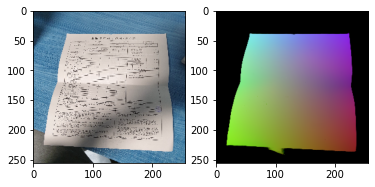

In [105]:
f1, axarr1 = plt.subplots(1, 2)
axarr1[0].imshow(img)
axarr1[1].imshow(pred_wc)
plt.show()

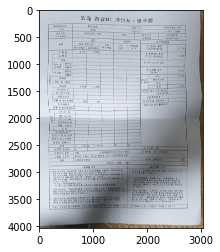

In [109]:
plt.imshow(uwpred)

In [113]:
cv2.imwrite('_rec.jpg', (uwpred*255.).astype(np.uint8)[:,:,::-1])


True